# Chapter02 머신러닝 프로젝트 처음부터 끝까지

캘리포니아 인구조사 데이터를 사용해 캘리포니아 주택 가격 모델 만들기

- **지도 학습** : 각 샘플이 레이블(주택 가격)을 가지고 있음

- **단변량, 다중 회귀** 문제 : 예측에 사용할 특성이 여러 개이며, 하나의 값 (주택 가격)을 예측하므로


### 2.3 데이터 가져오기

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close() #데이터 다운로드, tgz -> csv로 압축해제

In [2]:
fetch_housing_data()  # 현재 작업공간에 'datasets/housing' 디렉터리를 만들고 
                      # housing.tgz 파일을 내려받고 같은 디렉터리에 압축을 풀어 housing.csv 파일을 만듦

In [3]:
import pandas as pd

# pandas로 데이터 읽어 들이는 함수
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.shape   # 10개의 특성을 가진 20640개의 데이터

(20640, 10)

In [6]:
housing.info()  # 데이터에 대한 간략한 설명, 각 특성의 NULL이 아닌 값의 개수 확인

# total_bedrooms 특성에 207개 샘플이 NULL값을 가지고 있다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts()   # 특성의 값들을 세어줌

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()  # 숫자형 특성의 요약 정보

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


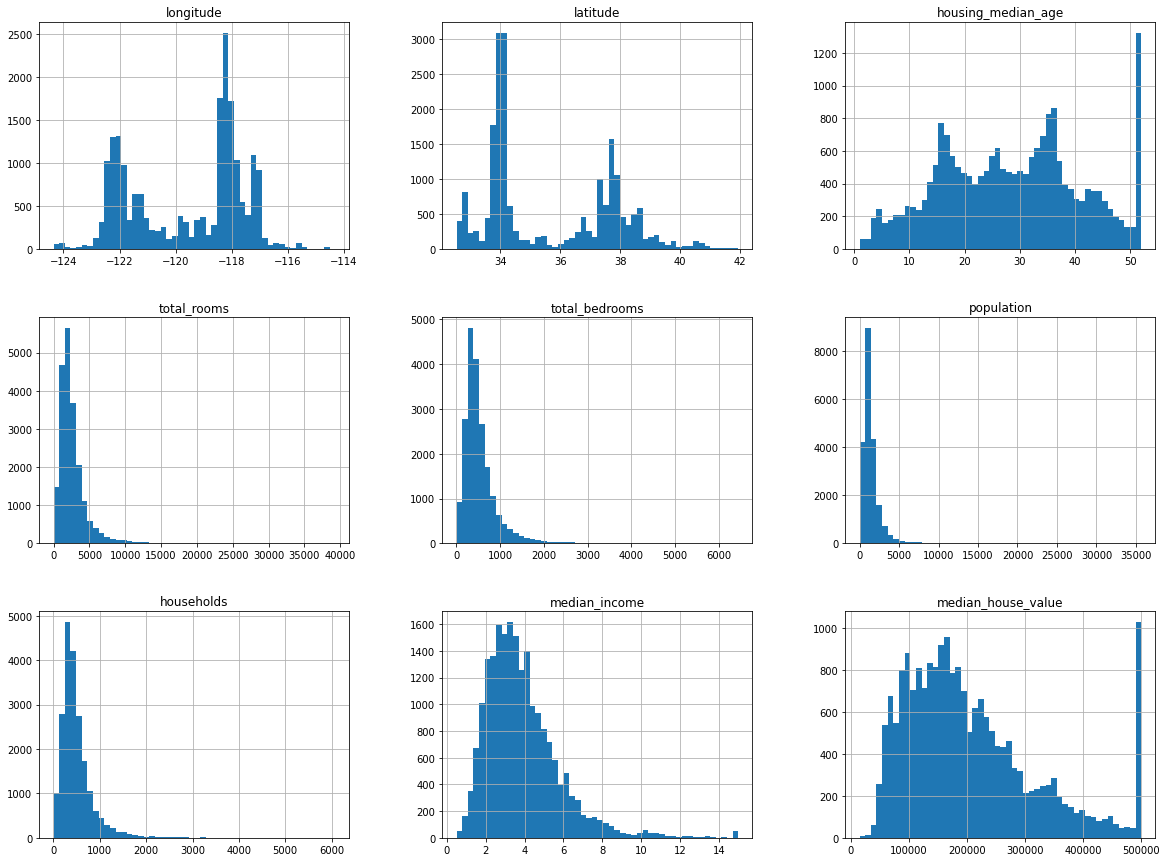

In [9]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

타깃 값 : median_house_value

최댓값과 최솟값을 한정했다. -->

1. 한계를 늘려 한곗값 밖의 구역에 대한 정확한 레이블을 구한다.

2. 훈련 세트에서 한곗값을 넘는 구역을 제거한다.

In [10]:
import numpy as np

# 테스트 세트 떼어내는 메서드
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"train_set: {len(train_set)}\n test_set: {len(test_set)}")

train_set: 16512
 test_set: 4128


In [12]:
# 데이터가 갱신될 때마다 생긴는 문제를 해결하기 위해 [식별자 칼럼으로 테스트셋을 분리해주는 메서드]

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()   # 'index' 열이 추가된 데이터프레임을 반환합니다

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
# longitude(경도), latitude(위도)는 거의 변하지 않으므로 이 특성들로 'id'열을 추가할 수도 있다

housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [15]:
housing_with_id['id'].head().to_frame()   # 경도, 위도로 만든 'id'열

,id
0,-122192.12
1,-122182.14
2,-122202.15
3,-122212.15
4,-122212.15


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**계층적 샘플링** : 

- 모집단을 여러개의 층으로 구분하여, 각 층에서 n개씩 랜덤하게 추출하는 방법

- 순수한 무작위 샘플링 방식은 데이터의 크기가 충분히 크지 않은 상황 등 샘플링 편향이 발생할 수 있는 가능성이 생길 수 있음

- 전체 데이터를 계층별 그룹으로 나눈 뒤, 테스트 세트가 전체 데이터의 각 계층의 계수 비율 만큼 샘플링함

In [123]:
# 예를 들어 'median_income (중간소득)'이 중요한 특성이라고 치면, 
# 중간소득의 비율이 train, test 세트에 각각 골고루 들어가야 하므로
# median_income 을 기준으로 계층적 샘플링을 하기 위해 알맞은 범주로 나눠준다
housing["income_cat"] = pd.cut(housing['median_income'],    # median_income을 범주화시킨 'income_cat' 특성을 새로 만듦
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],  # 범위를 원하는대로 나눠줌
                               labels=[1, 2, 3, 4, 5])                # 카테고리 이름 (순서대로 들어감)
# pd.cut(): 카테고리 5개를 가진 '소득' 카테고리 특성을 만듦

In [126]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [113]:
housing['income_cat'].value_counts(sort=False)  # 새로 만든 특성

1     822
2    6581
3    7236
4    3639
5    2362
Name: income_cat, dtype: int64

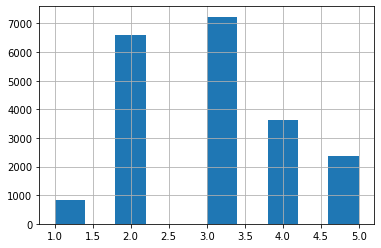

In [114]:
housing['income_cat'].hist()

In [132]:
from sklearn.model_selection import StratifiedShuffleSplit  # 계층 샘플링하는 메서드

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # n_splits=1: 1번만 나눈다는 의미 
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    print(len(train_index), len(test_index))

16512 4128


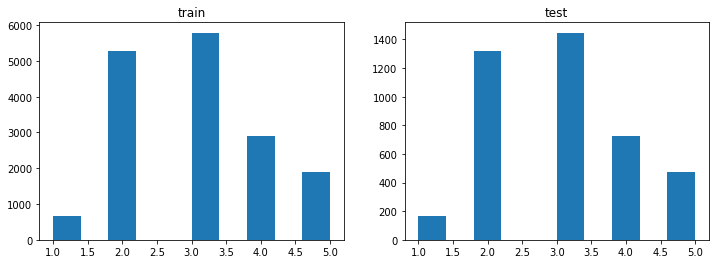

In [133]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1, title='train')
ax1.hist(strat_train_set['income_cat'])
ax2 = fig.add_subplot(1, 2, 2, title='test')
ax2.hist(strat_test_set['income_cat'])
plt.show()

계층 샘플링이 잘 이루어졌다!

In [134]:
# income_cat 특성을 삭제해서 원상태로 복구
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [137]:
a = np.array([[1,2,3],[4,5,6]])
print(a.shape)
print(np.sum(a, axis=0).shape)
print(np.sum(a, axis=1).shape)

# axis=n 으로 np연산을 해주면 axis(n)이 없어진다고 생각하면 안 헷갈림!!

(2, 3)
(3,)
(2,)


### 2.4 데이터 이해를 위한 탐색과 시각화

In [138]:
housing = strat_train_set.copy()    # 훈련 세트 복사

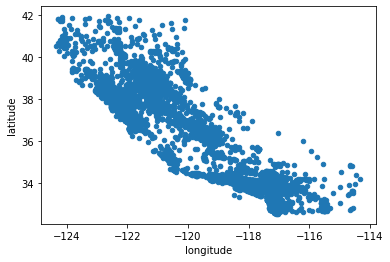

In [140]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()